# Refinement with emcee: Neutron data for PbSO4


## Bayesian refinment
* Experimental data D ($y_\text{exp}$) 
* $\boldsymbol{x}$ parameters to be refined $\boldsymbol{x}$=($\boldsymbol{x}_\text{experiment}$, $\boldsymbol{x}_\text{instrument}$, $\boldsymbol{x}_\text{sample}$)
* Simulated diffraction pattern $y_\text{sim}=f(\boldsymbol{x})$

**Goal:** Finding the posterior probability distribution over parameters, $P(\boldsymbol{x}|D)$,  given some data D  and prior knowledge.

The posterior for parameters is

\begin{equation}
\large
\underbrace{P(\boldsymbol{x}|D)}_\text{Posterior} = \underbrace{P(D|\boldsymbol{x})}_\text{Likelihood}\, \, \underbrace{P(\boldsymbol{x})}_\text{Priors}
\end{equation}

### Likelihood IID normal errors 
Identical and independent normal distributed errors
\begin{equation}
\large
y_\text{exp,i} = y_\text{sim,i} + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(\mu=0, \sigma^2)
\end{equation}
meaning
\begin{equation}
\large
P(D|\boldsymbol{x}) \propto \exp{\left (-\vert\vert \boldsymbol{y}_\text{target} - \boldsymbol{y}_\text{model}\vert\vert^2/2\sigma^2 \right )}
\end{equation}

### Likelihood with heteroscedasticity
Including heteroscedasticity via another approach (common for count data?) is
\begin{equation}
\large
\epsilon_i \sim \mathcal{N}(\mu=0, \sigma^2_i = y_\text{exp,i}).
\end{equation}

### Likelihood
From paper "Use of Bayesian Inference in Crystallographic Structure Refinement via Full Diffraction Profile Analysis" (doi: https://doi.org/10.1038/srep31625), they use something along the lines of

\begin{equation}
\large
\epsilon_i \sim \mathcal{N}(\mu=0, \sigma^2_i = \sigma^2 \cdot y_\text{exp,i}).
\end{equation}

Additionally, they add correlation between $\epsilon_i$ and $\epsilon_j$ if i,j are close.



### Posterior 
Finding parameters that maximizes the posterior is equvivalent to regular optimization (least-squares).

Evaluating the posterior via MCMC-sampling (emcee).

In [1]:
# esyScience
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import corner

sns.set_context('notebook')

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

GSAS-II binary directory: /home/erikfr/.local/lib/python3.8/site-packages/GSASII/bindist
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


In [2]:
# help functions

def print_parameters(job):
    print(job.phases[0].scale)
    print(job.pattern.zero_shift)
    print(job.parameters.resolution_u)
    print(job.parameters.resolution_v)
    print(job.parameters.resolution_w)
    print(job.backgrounds[0][0])
    print(job.backgrounds[0][1])
    

def compute_rmse(y1, y2):
    delta_y = y1-y2
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse

In [3]:
theta_0 = np.array([5, 1.0, 0.125, 0.18, -0.4, 0.4, 210, 230])


def generate_starting_theta():
    theta = theta_0.copy()
    theta[0] += np.random.normal(0, 1) # sigma
    theta[1] += np.random.normal(0, 0.05) # scale
    theta[2] += np.random.normal(0, 0.01) # zero-shift
    theta[3] += np.random.normal(0, 0.01) # u
    theta[4] += np.random.normal(0, 0.01) # v
    theta[5] += np.random.normal(0, 0.01) # w
    theta[6] += np.random.normal(0, 10)   # bkground-1
    theta[7] += np.random.normal(0, 10)   # bkground-2
    return theta


def set_job_parameters(job, theta):
    job.phases[0].scale = theta[1]
    job.pattern.zero_shift = theta[2]
    job.parameters.resolution_u = theta[3]
    job.parameters.resolution_v = theta[4]
    job.parameters.resolution_w = theta[5]
    job.backgrounds[0][0].y = theta[6]
    job.backgrounds[0][1].y = theta[7]

In [9]:
# load cif
cif_fname = '../datasets/neutron_powder_PbSO4/PbSO4.cif'
phases = Phases.from_cif_file(cif_fname)
phase = phases[0]

# load diffraction data
meas_fname = '../datasets/neutron_powder_PbSO4/D1A@ILL.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print(meas_x.shape, meas_y.shape)

(2201,) (2201,)


In [13]:
# setup interface to CrysFML and job
#calculator = Calculator(interface_name='CrysFML')
calculator = Calculator(interface_name='CrysPy')

job = Job(phases=phases, interface=calculator)

# setup 
job.parameters.wavelength = 1.912

# add background
bkg = PointBackground(linked_experiment='PbSO4')
bkg.append(BackgroundPoint.from_pars(meas_x[0], 200))
bkg.append(BackgroundPoint.from_pars(meas_x[-1], 250))
job.set_background(bkg)

Temp CIF: /tmp/easydiffraction_temp.cif


[ 5.00e+00  1.00e+00  1.25e-01  1.80e-01 -4.00e-01  4.00e-01  2.10e+02
  2.30e+02]
<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>
<Parameter 'zero_shift': 0.125+/-0 (fixed), bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.18+/-0 (fixed), bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.4+/-0 (fixed), bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.4+/-0 (fixed), bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 210.0+/-0 (fixed), bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 230.0+/-0 (fixed), bounds=[-inf:inf]>
Initial RMSE: 71.60127235042337


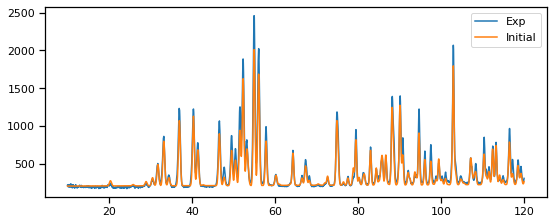

In [14]:
# Before fitting, theta_0
print(theta_0)

set_job_parameters(job, theta_0)
y_initial = calculator.fit_func(meas_x)
rmse_initial = compute_rmse(meas_y, y_initial)

print_parameters(job)

print('Initial RMSE:', rmse_initial)


fig = plt.figure(figsize=(9, 3.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.legend()

In [15]:
# define all probabilities, priors, likelihoods, posterios

def log_gaussian_likelihood(theta):

    set_job_parameters(job, theta)
    sigma = theta[0]
    
    # if calculation fails for any reason, return -inf
    try:
        y_predicted = calculator.fit_func(meas_x)
    except ArithmeticError:
        print('  Exception from calc found, -inf')
        return -np.inf

    # if y contains nan then return -inf
    if np.any(np.isnan(y_predicted)):
        print('  nan found in predicted values, -inf')
        return -np.inf

    LL = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (meas_y - y_predicted) ** 2 / sigma ** 2)
    
    sigmas = sigma * np.sqrt(meas_y)
    LL = -0.5 * np.sum(np.log(2 * np.pi * sigmas ** 2) + (meas_y - y_predicted) ** 2 / sigmas ** 2)

    return LL


def log_prior(theta):

    sigma = theta[0]
    
    if sigma < 0 or sigma > 1000:
        return -np.inf
    
    return 0


def log_posterior(theta):
    return log_prior(theta) + log_gaussian_likelihood(theta)

In [16]:
# MCMC parameters
n_walkers = 20   # number of MCMC walkers
n_every = 10      # keep every x:th sample
n_steps = 2000 // n_every  # steps per walker
n_cols = 8

# starting points for MCMC

theta_start = []
for _ in range(n_walkers):
    theta_start.append(generate_starting_theta())

theta_start = np.array(theta_start).copy()
# sanity check starting points such that there is no nans
for theta in theta_start:
    print(log_posterior(theta))

-12197.897634880415
-12248.526850508833
-12517.325927566704
-12247.78884971347
-12158.382617088078
-12017.490473372869
-12362.845457047493
-12366.92111589481
-12222.76204723504
-11877.999645031128
-12345.259296537246
-12712.166099804042
-12326.21644648346
-11846.889379830009
-12008.22926420808
-12301.465597300796
-11782.4111836386
-12142.868337841035
-12217.266286674285
-12025.659988914482


In [17]:
# sample
sampler = emcee.EnsembleSampler(n_walkers, n_cols, log_posterior)
sampler.run_mcmc(theta_start, n_steps, progress=True, thin_by=n_every)
print('done!')

100%|███████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [2:16:09<00:00,  4.08s/it]

done!


In [23]:
samples_chain = sampler.chain
logp = sampler.lnprobability
print(logp.shape)

n_eq = 200 // n_every
samples_flat = samples_chain[:, n_eq:, :].reshape(-1, n_cols)

(20, 200)


(20, 200, 8)


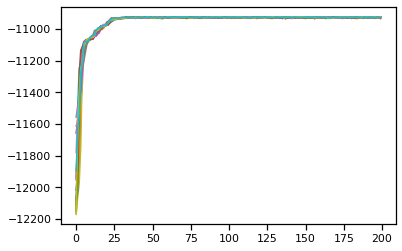

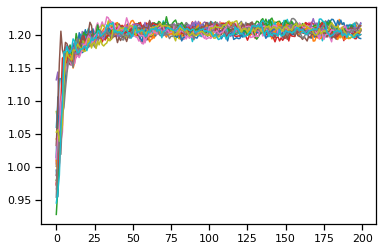

In [24]:
# sanity plots
plt.figure()
plt.plot(logp.T);

plt.figure()
plt.plot(samples_chain[:, :, 1].T);
print(samples_chain.shape)

In [25]:

names = ['sigma (dy)', 'scale', 'zero_shift', 'resolution_u', 'resolution_v', 'resolution_w', 'intensity', 'intensity']

def print_all_params(names, values, errs):
    for n, v, e in zip(names, values, errs):
        print(f'{n:15} {v:12.5f} , err {e:8.5f}')

# select best model
ind = np.argmax(logp)
hp_loc = np.unravel_index(ind, logp.shape)
assert logp[hp_loc] == logp.max()
theta_best = samples_chain[hp_loc]

set_job_parameters(job, theta_best)
y = calculator.fit_func(meas_x)
rmse = compute_rmse(meas_y, y)


# estimate errors
stds = samples_flat.std(axis=0)
print(f'Best model: RMSE {rmse:.5f}, sigma {theta_best[0]:.3f}')
print()
print_all_params(names, theta_best, stds)




Best model: RMSE 46.41102, sigma 1.939

sigma (dy)           1.93908 , err  0.02978
scale                1.20904 , err  0.00684
zero_shift           0.12200 , err  0.00120
resolution_u         0.20463 , err  0.01965
resolution_v        -0.49486 , err  0.03814
resolution_w         0.48771 , err  0.01610
intensity          197.16263 , err  1.80352
intensity          239.69534 , err  1.97808


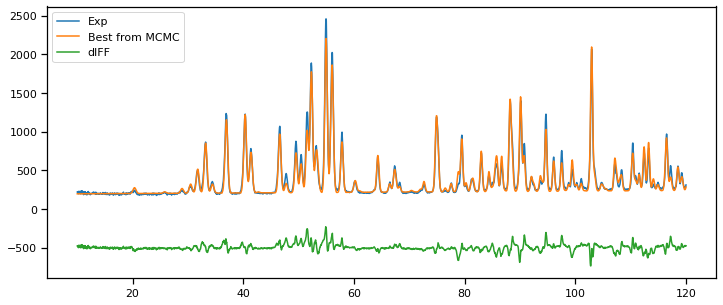

In [26]:

# plot
fig = plt.figure(figsize=(12, 5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y, '-', label='Best from MCMC')
plt.plot(meas_x, meas_y-y-500, '-', label='dIFF')
plt.legend();


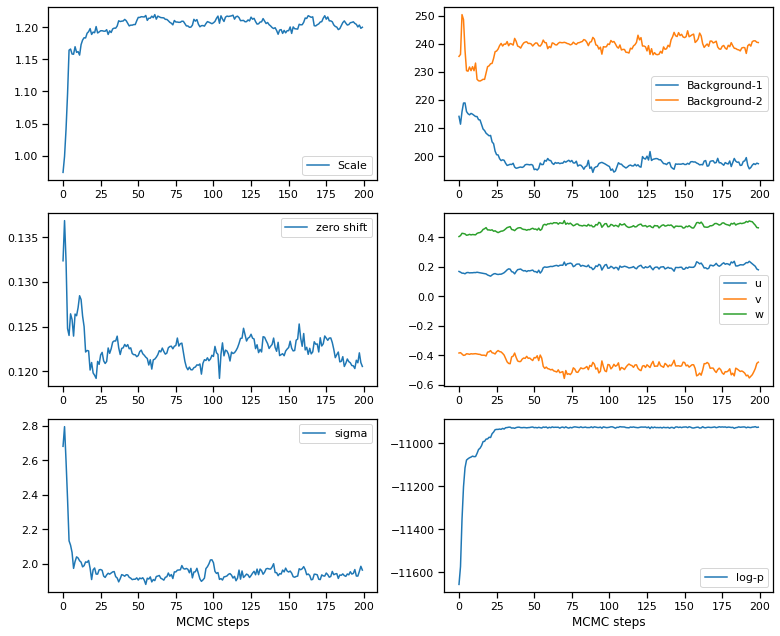

In [27]:
# plot walker
fig = plt.figure(figsize=(11, 9))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

walker_ind = 13

samples_walker = samples_chain[walker_ind]
p_walker = logp[walker_ind]
#p_walker = np.exp(p_walker-logp.max())

ax1.plot(samples_walker[:, 1], label='Scale')
ax2.plot(samples_walker[:, 6], label='Background-1')
ax2.plot(samples_walker[:, 7], label='Background-2')

ax3.plot(samples_walker[:, 2], label='zero shift')
ax4.plot(samples_walker[:, 3], label='u')
ax4.plot(samples_walker[:, 4], label='v')
ax4.plot(samples_walker[:, 5], label='w')

ax5.plot(samples_walker[:, 0], label='sigma')

ax6.plot(p_walker, label='log-p')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()

ax5.set_xlabel('MCMC steps')
ax6.set_xlabel('MCMC steps')

fig.tight_layout()

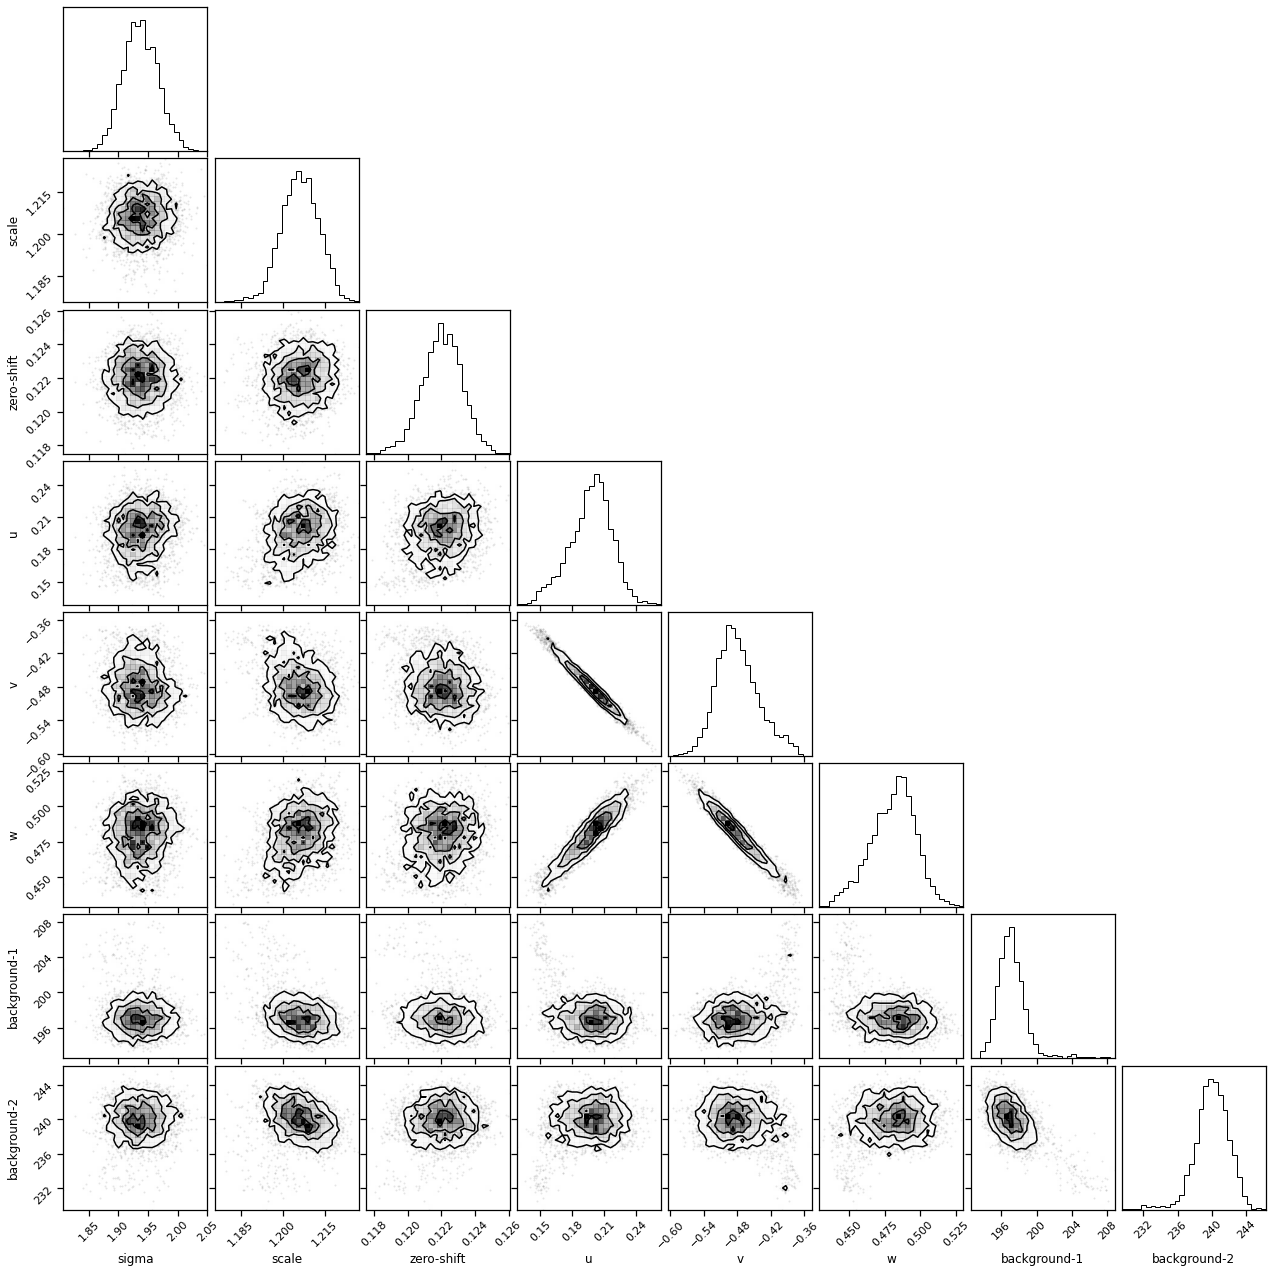

In [28]:
labels = ['sigma', 'scale', 'zero-shift', 'u', 'v', 'w', 'background-1', 'background-2']
corner.corner(samples_flat, labels=labels, bins=30);